# 11. Arrests / Los Angeles demographics - Racial Distribution

This notebook will perform an EDA over the Department 49-00033 (Los Angeles, CA) arrests and demographics.

A hope is that this will provide some insights and experience into plotting tools, e.g. folium and holoviews, and that it may also give some insights into the data and how it should be wrangled. Hope for the best (:

# Racial Distribtion

In this I will try to visualize the racial distribution of LA. The best way to do this seem to be using a racial dot map. Let's do it!

# Load data

In [21]:
import collections

import folium
import folium.plugins
import geopandas
import matplotlib.lines
import matplotlib.pyplot
import numpy
import pandas
import seaborn
import shapely

from cpe_help import Department, util

In [2]:
dept = Department('49-00033')
dept

Department('49-00033')

## Arrests

In [3]:
!ls {dept.external_dir}

49-00033_Arrests_2015.csv  shapefiles


In [4]:
raw_arrests = pandas.read_csv(dept.external_dir / '49-00033_Arrests_2015.csv', low_memory=False)
raw_arrests.head()

,INCIDENT_DATE,INCIDENT_TIME,INCIDENT_UNIQUE_IDENTIFIER,LOCATION_DISTRICT,LOCATION_TYPE,UNKNOWN_FIELD_TYPE,SUBJECT_AGE,SUBJECT_GENDER,SUBJECT_RACE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON,UNKNOWN_FIELD_TYPE.2,CHARGE,CHARGE_DESCRIPTION,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,CROSS_STREET,LOCATION_LATITUDE,LOCATION_LONGITUDE
0,ARST DATE,TIME,RPT_ID,AREA,AREA_DESC,RD,AGE,SEX_CD,DESCENT_CD,CHRG_GRP_CD,GRP_DESC,ARST_TYP_CD,CHARGE,CHRG_DESC,LOCATION,CRSST,Location Lat,Location Lon
1,12/31/15 0:00,2345,4538991,14,Pacific,1435,43,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,3500 MCLAUGHLIN AV,NaN,34.0141,-118.4288
2,12/31/15 0:00,2330,4538996,1,Central,101,27,M,W,4,Aggravated Assault,F,273.5(A)PC,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,900 FIGUEROA TR,NaN,34.0663,-118.2441
3,12/31/15 0:00,2320,4539142,6,Hollywood,646,31,M,W,16,Narcotic Drug Laws,M,11350(A)HS,POSSESSION OF CONTROLLED SUBSTANCE,6300 HOLLYWOOD BL,NaN,34.1016,-118.3267
4,12/31/15 0:00,2319,4538947,21,Topanga,2189,28,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,VENTURA FY,WINNETKA,34.1723,-118.5709


## Block groups + precincts + census tracts

In [5]:
bgs = dept.load_block_groups()
precincts = dept.load_police_precincts()
tracts = dept.load_census_tracts()
precincts.head()

,slug,set,kind,external_i,name,display_na,url,number,phone_numb,address,...,RACE_NH_OTHER,RACE_NH_MULTIRACIAL,RACE_HISPANIC,POVERTY_TOTAL,POVERTY_BPL,POVERTY_NOT_BPL,EMPLOYMENT_TOTAL,EMPLOYMENT_EMPLOYED,EMPLOYMENT_UNEMPLOYED,geometry
0,77th-street-lapd-division,LAPD Divisions,LAPD Division,12,77th Street,77th Street LAPD Division,http://www.lapdonline.org/77th_street_communit...,12,213-485-4164,7600 S. Broadway,...,870.694270,1768.269866,103196.108821,178466.603994,54997.983164,123468.620830,81277.612528,70819.597526,10458.015002,POLYGON ((-118.3148948951553 34.00371678060566...
1,central-lapd-division,LAPD Divisions,LAPD Division,1,Central,Central LAPD Division,http://www.lapdonline.org/central_community_po...,1,213-485-3294,251 E. 6th St.,...,238.896974,1890.706219,15657.215214,54107.577791,19813.317814,34294.259978,29314.517019,26605.679738,2708.837281,POLYGON ((-118.2243816590658 34.06850962588265...
2,devonshire-lapd-division,LAPD Divisions,LAPD Division,17,Devonshire,Devonshire LAPD Division,http://www.lapdonline.org/devonshire_community...,17,818-832-0633,10250 Etiwanda Ave.,...,733.627030,6904.626033,69810.778569,223450.798257,23836.680790,199614.117467,121395.753742,112632.356647,8763.397095,POLYGON ((-118.4896378723103 34.31514263477411...
3,foothill-lapd-division,LAPD Divisions,LAPD Division,16,Foothill,Foothill LAPD Division,http://www.lapdonline.org/foothill_community_p...,16,818-756-8861,12760 Osborne St.,...,638.315695,2237.869971,124931.063478,190061.556495,36926.103431,153135.453064,96782.303394,86798.574242,9983.729152,POLYGON ((-118.3829144583267 34.29425373977321...
4,harbor-lapd-division,LAPD Divisions,LAPD Division,5,Harbor,Harbor LAPD Division,http://www.lapdonline.org/harbor_community_pol...,5,310-726-7700,2175 John S. Gibson Blvd.,...,450.633662,4938.067878,112627.182346,180304.679827,38765.744715,141538.935112,91790.858253,82673.895206,9116.963048,POLYGON ((-118.2815067203804 33.86634772230949...


# Preprocess

In [6]:
raw_arrests.shape

(126855, 18)

In [7]:
'{:.2%}'.format(
    (raw_arrests['LOCATION_LATITUDE'] == '0').mean())

'5.32%'

In [8]:
raw_arrests.head().T

,0,1,2,3,4
INCIDENT_DATE,ARST DATE,12/31/15 0:00,12/31/15 0:00,12/31/15 0:00,12/31/15 0:00
INCIDENT_TIME,TIME,2345,2330,2320,2319
INCIDENT_UNIQUE_IDENTIFIER,RPT_ID,4538991,4538996,4539142,4538947
LOCATION_DISTRICT,AREA,14,1,6,21
LOCATION_TYPE,AREA_DESC,Pacific,Central,Hollywood,Topanga
UNKNOWN_FIELD_TYPE,RD,1435,101,646,2189
SUBJECT_AGE,AGE,43,27,31,28
SUBJECT_GENDER,SEX_CD,M,M,M,M
SUBJECT_RACE,DESCENT_CD,H,W,W,H
UNKNOWN_FIELD_TYPE.1,CHRG_GRP_CD,22,4,16,22


In [9]:
variables = pandas.Series(raw_arrests.columns, index=raw_arrests.loc[0])
arrests = raw_arrests.loc[1:].copy()

# process date and drop time
arrests['INCIDENT_DATE'] = pandas.to_datetime(
    arrests['INCIDENT_DATE'], format='%m/%d/%y %H:%M')
arrests = arrests.drop('INCIDENT_TIME', axis=1)

# convert dtypes
numeric_columns = [
    'LOCATION_LATITUDE',
    'LOCATION_LONGITUDE',
]
arrests[numeric_columns] = arrests[numeric_columns].apply(pandas.to_numeric)

# drop entries where lat/lon is unknown
# (5.32% of the entries)
# (could have retrieved approximate lat/lon from address)
arrests = arrests[
    (arrests['LOCATION_LATITUDE'] != 0) &
    (arrests['LOCATION_LONGITUDE'] != 0)
]

# generate points from location
points = [shapely.geometry.Point(x, y)
          for x, y in zip(
              arrests['LOCATION_LONGITUDE'], arrests['LOCATION_LATITUDE'])]

# convert to GeoDataFrame
arrests = geopandas.GeoDataFrame(
    arrests,
    geometry=points,
    crs=util.crs.epsg4326,
)
arrests = arrests.to_crs(precincts.crs)

# EDA

In [10]:
arrests_sample = arrests.sample(2000, random_state=1)
arrests_sample_big = arrests.sample(10000, random_state=1)

In [11]:
print(" Precincts CRS: {}".format(precincts.crs))
print(" Arrests CRS: {}".format(arrests.crs))
print(" Tracts CRS: {}".format(tracts.crs))
print(" BGs CRS: {}".format(bgs.crs))

 Precincts CRS: {'init': 'epsg:4269'}
 Arrests CRS: {'init': 'epsg:4269'}
 Tracts CRS: {'init': 'epsg:4269'}
 BGs CRS: {'init': 'epsg:4269'}


In [12]:
# only use intersecting regions
arrests_sample = arrests_sample[arrests_sample.intersects(precincts.unary_union)]
arrests_sample_big = arrests_sample_big[arrests_sample_big.intersects(precincts.unary_union)]
tracts = tracts[tracts.intersects(precincts.unary_union)]
bgs = bgs[bgs.intersects(precincts.unary_union)]

# set up equal-area projection
proj = util.crs.equal_area_from_geodf(tracts)
precincts = precincts.to_crs(proj)
arrests_sample = arrests_sample.to_crs(proj)
arrests_sample_big = arrests_sample_big.to_crs(proj)
tracts = tracts.to_crs(proj)
bgs = bgs.to_crs(proj)

In [13]:
def random_point(polygon):
    xmin, ymin, xmax, ymax = polygon.bounds
    x = numpy.random.uniform(xmin, xmax)
    y = numpy.random.uniform(ymin, ymax)
    point = shapely.geometry.Point(x, y)
    if polygon.contains(point):
        return point
    else:
        return random_point(polygon)
    
def random_points(polygon, count):
    return [random_point(polygon) for _ in range(count)]

def multiple_random_points(polygons, counts, random_state=None):
    if random_state is not None:
        numpy.random.seed(random_state)
        
    return [point
            for polygon, count in zip(polygons, counts)
            for point in random_points(polygon, count)]

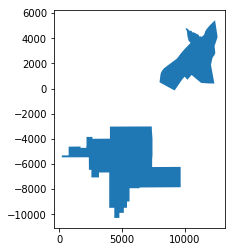

In [16]:
polygons = precincts.geometry[:2]
polygons.plot()

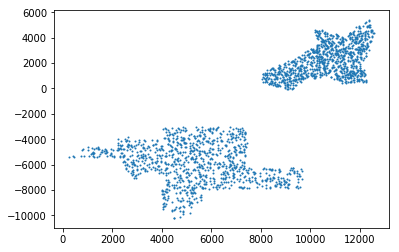

In [17]:
points = multiple_random_points(polygons, [1000, 1000], 1)

matplotlib.pyplot.scatter(
    [p.x for p in points],
    [p.y for p in points],
    s=1,
)

In [18]:
df = bgs

geoms = df.geometry
white = df['RACE_NH_WHITE']
black = df['RACE_NH_BLACK']
asian = df['RACE_NH_ASIAN']
other = df['RACE_NH_INDIAN'] + df['RACE_NH_HAWAIIAN'] + df['RACE_NH_OTHER'] + df['RACE_NH_MULTIRACIAL']
hispanic = df['RACE_HISPANIC']

Text(0, 0.5, 'Population')

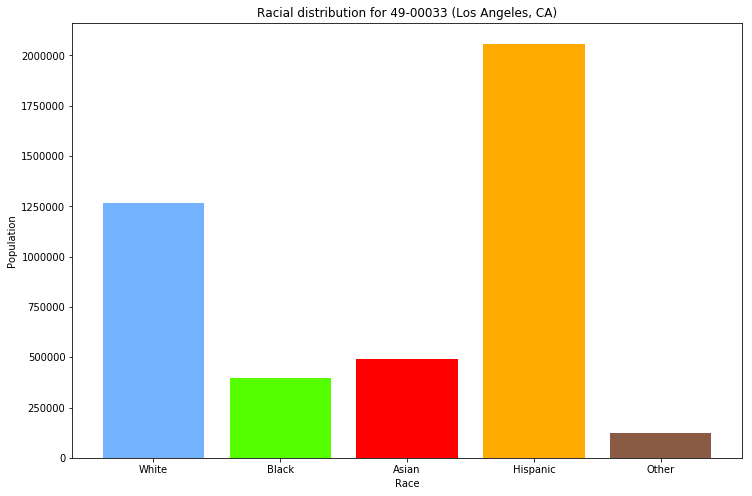

In [19]:
names = ['White', 'Black', 'Asian', 'Hispanic', 'Other']
colors = ['#73B2FF', '#55FF00', '#FF0000', '#FFAA00', '#895A44']
values = [white.sum(), black.sum(), asian.sum(), hispanic.sum(), other.sum()]

fig, ax = matplotlib.pyplot.subplots(figsize=(12, 8))
ax.bar(names, values, color=colors)
ax.set_title('Racial distribution for {}'.format(dept.full_name))
ax.set_xlabel('Race')
ax.set_ylabel('Population')

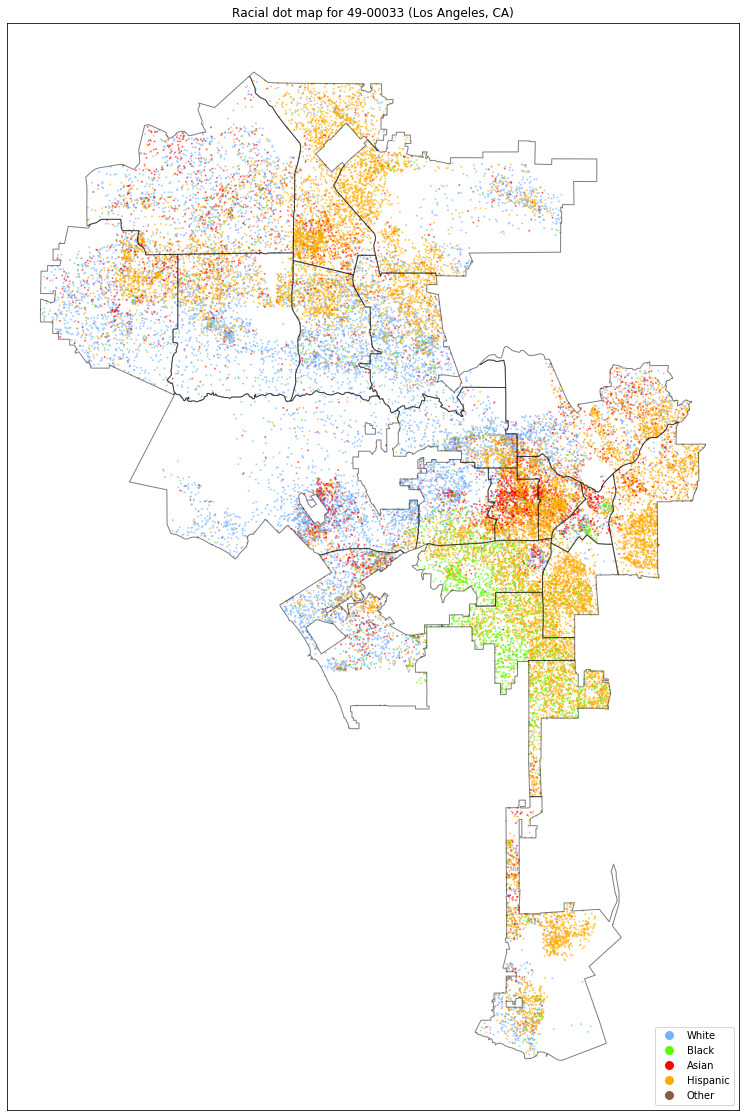

In [20]:
PlotPoint = collections.namedtuple('PlotPoint', 'x y color')

fig, ax = matplotlib.pyplot.subplots(figsize=(20, 20))

polygons = geoms
name_lst = ['White', 'Black', 'Asian', 'Hispanic', 'Other']
counts_lst = [white, black, asian, hispanic, other]
color_lst = ['#73B2FF', '#55FF00', '#FF0000', '#FFAA00', '#895A44']

total_points = []
for counts, color in zip(counts_lst, color_lst):
    counts = counts // 100
    points = multiple_random_points(polygons, counts)
    total_points += [PlotPoint(p.x, p.y, color) for p in points]
    
# must shuffle points, otherwise specified order starts to matter
numpy.random.shuffle(total_points)
    
# remove points outside police area
region = precincts.unary_union
total_points = [p
                for p in total_points
                if region.contains(shapely.geometry.Point(p.x, p.y))]

ax.scatter(
    [p.x for p in total_points],
    [p.y for p in total_points],
    c=[p.color for p in total_points],
    s=1,
    alpha=0.5,
)
precincts.plot(
    ax=ax,
    color='none',
    edgecolor=(0, 0, 0, 0.5)
)

legend_handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=10) 
    for label, color in zip(name_lst, color_lst)
]
ax.legend(handles=legend_handles, loc='lower right')

ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Racial dot map for {}'.format(dept.full_name));